# Testing EfficientDet for Person Detection

In this notebook, we show how to use a pretrained EfficientDet model for the task of person detection.

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.nn import DataParallel

sys.path.append("..")

from data.data_loaders import get_detection_dataset
from lib.detection_coco_utils import get_coco_api_from_dataset
from lib.detection_coco_eval import CocoEvaluator
from lib.model_setup import setup_detector, load_checkpoint
import lib.utils as utils
from lib.bounding_box import bbox_filtering
import lib.visualizations as visualizations
from CONFIG import CONFIG

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
exp_name = os.path.join("detector_tests", "faster_rcnn_test")
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
data_path = CONFIG["paths"]["data_path"]

In [4]:
obj_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
            'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
            'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie',
            'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
            'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv',
            'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
            'refrigerator', '', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
            'toothbrush']

# 1. Loading Model

In [5]:
# EfficcientDet pretrained on COCO (provided by authors9)
# model = setup_detector(model_name="efficientdet", num_classes=len(obj_list))
# checkpoint_path = os.path.join(CONFIG["paths"]["pretrained_path"], "EfficientDet", "efficientdet_d0.pth")

# EfficientDet fine-tuned on Styled-COCO for Person Detection
model = setup_detector(model_name="efficientdet", num_classes=1)
checkpoint_path = os.path.join(CONFIG["paths"]["pretrained_path"], "EfficientDet", "efficientdet-d0_styled_10epochs.pth")

# Faster R-CNN fine-tuned on Styled-COCO for Person Detection
model2 = setup_detector(model_name="faster_rcnn", num_classes=1)
detector_path = os.path.join(CONFIG["paths"]["experiments_path"], "detector_tests", "faster_rcnn_test")
checkpoint_path2 = os.path.join(detector_path, "models", "detector", "checkpoint_epoch_25.pth")
model2 = DataParallel(model2)

In [6]:
model = load_checkpoint(checkpoint_path=checkpoint_path, model=model, only_model=True)
model = model.eval().cuda()

model2 = load_checkpoint(checkpoint_path=checkpoint_path2, model=model2, only_model=True)
model2 = model2.eval().cuda()

# 2. Loading Data

In [7]:
exp_data = utils.load_experiment_parameters(test_exp)
# exp_data["dataset"]["dataset_name"] = "coco"
exp_data["dataset"]["dataset_name"] = "styled_coco"

In [8]:
train_loader, valid_loader, train_set,\
    valid_set = get_detection_dataset(exp_data=exp_data, train=True, validation=True, get_dataset=True,
                                      shuffle_train=False, shuffle_valid=False, class_ids=[1])

Loading /home/corrales/MasterThesis/data/mapping_dicts/train_dict.json...
loading annotations into memory...
Done (t=7.84s)
creating index...
index created!
Loading /home/corrales/MasterThesis/data/mapping_dicts/valid_dict.json...
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


In [9]:
img, meta = valid_set[15]
# img, meta = valid_set[3]
imgs = [img]
# img, meta = next(iter(train_loader))

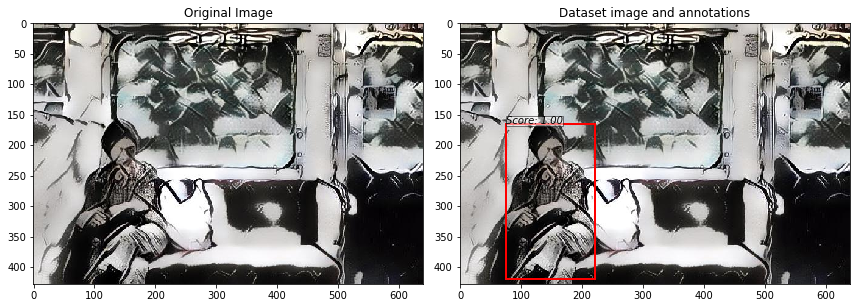

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 5)

title = "Original Image"
visualizations.visualize_image(img.transpose(1,2,0), title=title, ax=ax[0])

title = "Dataset image and annotations"
visualizations.visualize_bbox(img.transpose(1,2,0), boxes=meta['targets']["boxes"], labels=meta['targets']["labels"],
                              scores=[1]*len(meta['targets']["labels"]), ax=ax[1], title=title)

plt.tight_layout()
plt.show()

# 3. Inference

In [11]:
forward_imgs = torch.Tensor(imgs) / 255

In [12]:
with torch.no_grad():
    out = model(forward_imgs)
    out2 = model2(forward_imgs)
boxes, labels, scores = bbox_filtering(out, filter_=0, thr=0.6)
boxes2, labels2, scores2 = bbox_filtering(out2, filter_=1, thr=0.6)

In [13]:
out

[{'boxes': tensor([[ 78.0346, 158.5658, 231.7200, 429.1811]]),
  'labels': tensor([1], dtype=torch.int32),
  'scores': tensor([0.8443])}]

In [14]:
out2

[{'boxes': tensor([[ 41.2182, 121.6411, 299.7623, 422.4254],
          [453.2545,  16.8454, 629.4437, 419.6466],
          [376.0289,  12.2446, 432.0173, 124.1228],
          [510.7924, 208.9023, 631.9774, 420.5833],
          [ 47.4933,  21.2181, 418.7821, 428.0000],
          [404.0996,  83.6119, 537.7961, 368.7458],
          [250.5152,  48.9150, 306.5327, 199.2088]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.6033, 0.1202, 0.0936, 0.0935, 0.0900, 0.0662, 0.0556],
         device='cuda:0')}]

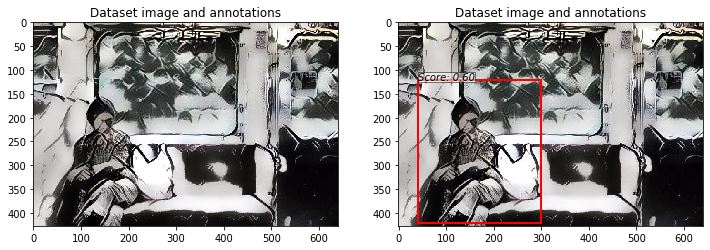

In [15]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 5)
visualizations.visualize_bbox(img.transpose(1,2,0), boxes=boxes[0], labels=labels[0],
                              scores=scores[0], title=title, ax=ax[0], fig=fig)
visualizations.visualize_bbox(img.transpose(1,2,0), boxes=boxes2[0], labels=labels2[0],
                              scores=scores2[0], title=title, ax=ax[1], fig=fig)
plt.show()

In [16]:
outputs = [{k: v.cpu() for k, v in t.items()} for t in out]

In [19]:
res = {meta["image_id"]: output for meta, output in zip([meta], outputs)}

In [20]:
res

{308394: {'boxes': tensor([[ 78.0346, 158.5658, 231.7200, 429.1811]]),
  'labels': tensor([1], dtype=torch.int32),
  'scores': tensor([0.8443])}}

In [23]:
coco = get_coco_api_from_dataset(valid_set)
iou_types = ["bbox"]

creating index...
index created!


In [24]:
coco_evaluator = CocoEvaluator(coco, iou_types)

In [25]:
coco_evaluator.update(res)



<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 